# Предсказание цен на автомобили реального рынка

- Денис Рыжов (denis.a.ryzhov@gmail.com)
- Дмитрий Коробов (Pls.mailbox@gmail.com)
- Дмитрий Копылов (kopiloff.dmitry@yandex.ru)

По условиям задачи: 
- нельзя пользоватться нейросетями
- данные должны быть либо взяты из общего доступа, либо скачаны, но не куплены.

Важно:

- качество предсказания;
- скорость предсказания;
- время обучения.

**For your consideration: Performance time of the whole code is about 11 min with my laptop.**

    AMD Ryzen 5 3500U
    RAM 6 GiB @ 2.1 GHz; 4 cores    
    GPU — None

## Краткий отчёт

Работа состояла из 3 этапов:

1. Добыча данных (Data mining)
2. Анализ данных и конструирование признаков (EDA and Feature engineering)
3. Исследование, выбор схемы и настройка моделей (Investigation, choice of prediction scheme and model adjustment)

### 1 Добыча данных (Data mining)

Данные были скачаны с сайта *avto.ru*, распарсены и переведы в таблицу *csv*. Изначально извлечено 133274 записей, занимающие 129.1 MB памяти

### 2 Анализ данных и конструирование признаков (EDA and Feature engineering)

После удаления дубликатов (8846), обработки пропусков (удалено 17) и удаления аномалий (139 записей) для моделирования доступен датасет с 124271 записями. Аномалиями классифицированы редкие машины (напр. гоночные болиды) и редкие классы (электромобили — 91 ~0.07%, машины с «газовыми» двигателями — 19 ~0.015%), не характерные, по нашему мнению, для российского авторынка.

Всего доступно 62 признака: 4 численных, 2 упорядоченных категориальных и 56 «one-hot» категориальных признака (48 бинарных переменных — в основном описание доп.оборудовния).
Данные приведены к типам `int` и `category`, что позволило уменьшить объём памти занимаемым датасетом до 19 МБ.
Проведено нормирование численных данных при помощи `StandardScaler` и перекодировка «one-hot» переменных в duumy-переменные. Упорядоченные переменные не кодировались.

**Важно:** В качестве целевой переменной использовалась степень логарифма цены (степень равна 2/3). Такой подход позволил улучшить предсказания на несколько процентов MAPE.
Преобразование позволило сделать распределение целевого признака существенно равномернее. Степень логарифма подбиралась из соображений: свести медиану и среднего нового распределения к центру интервала изменения переменных (справа и слева от центра интервала — примерно равное число признаков). 

Определена функция метрики, рассчитывающая MAPE в процентах.
Данные поделены на пять выборок в трёх блоках:
- `train1` (3/9) и `valid1` (1/9) — обучающая и валидационная выборки для базовых моделей
- `train2` (3/9) и `valid2` (1/9) — обучающая и валидационная выборки для мета-модели
-`test` (1/9) - выборка для тестирования всей «сборки»
В обучающих выборках оказалось около 41400 записей, в остальных — по 13800.

### 3 Исследование, выбор схемы и настройка моделей (Investigationб choice of prediction scheme and model adjustment)

Общей схемой построения предсказателя была выбрана двухступенчатая модель стекинга. В качестве как базовых, так и мета моделей рассматривались:
- `DecisionTreeRegressor`
- `RandomForestRegressor`
- `LightGBM`
- `CatBoostRegressor`
- `LinearRegression` (только как мета-модель — блендинг)

`RandomForestRegressor`, `LightGBM`, `CatBoostRegressor` оптимизировались по гиперпараметрам при помощи циклической покоординатной оптимизации:



#### Оптимизация моделей по гиперпараметрам

Пока не достигался заданный максимальный уровень изменения метрики (`tolerance`=0.0001% для MAPE) осуществлялся циклический поиск минимума в пространстве гиперпараметров поиском минимума. Минимум искался на сетке по каждой координате внутри цикла. Каждый цикл осуществлял сужение диапазона поиска центрируясь на достигнутом на данном момент точки минимума. *Сейчас поиск сужен до двух последних циклов, поскольку в полной версии (на широком диапазоне) занимал существенное время.*



#### Выбор моделей

В качестве базовых моделей для стекинга рассматривались 4 упомянутые выше модели. Исследование их по параметрам, а также рассмотрение различных комбинаций в качестве «связки» базовых моделей показало, что в нашем случае будет использование нескольких моделей LightGBM с последующим простым усреднением их прогнозов на мета-этапе.

В конечном варианте собирается набор из 25 моделей LightGBM распределённых в пространстве гиперпараметров вокруг (и включая) лучшей базовой модели.

Исследование признаков при помощи метода `feature_importance` показывает, что наша «информационная достаточность» на этапе базовых моделей составляет 99%, т. е., добавление гипотетических новых признаков, скорее всего, даст только 1% прироста необходимой информации. При тех оговорках, что эта оценка основана на предположениях, что a) мы не пропустили какого-то важного признака, а добавляем признаки меньшей значимости б) распределение признаков по их «информационной значимости» близко к экспогенциальному (что в общем подтверждается из опыта). Стоит заметить, что модель показывала результаты существенно хуже без 46 признаков, описывающих дополнительную комплектацию.

Оказывается усреднение по предсказаниям 25 моделей способно улучшить конечное предсказание, поэтому все обученные модели переводятся на следующий этап, где их предсказания усредняются (бэггинг).
Ни модель линейной регрессии, ни любая из остальных 4 моделей, применённых в качестве мета модели не смогли улучшить результаты бэггинга.

Однако стоит заметить, что анализ «информационной важности» признаков (feature importance) для модели LightGBM показал, что предсказаний всего 25 моделей ей недостаточно для прогноза, а нужно120. Возможно получив столько признаков модель справится с большим разбросом предсказаний.

Однако a) такое предположение гадательно и главное b) требует больших временных рескрсов даже для такой «дёгкой» и быстрой модели как LightGBM.

Как показали исследования, очень важны данные. Самим данным присуща довольна большая дисперсия, и по видимому, именно поэтому простой бэггинг (усреднение) справляется так хорошо — ему свойственно хорошо уменьшать variance предсказаний.

### Итог

На основе 25 базовых моделей LightGBM строится усреднённое мета-предсказание (техника бэггинг). Параметры модели выбираются близкими в пространстве гиперпараметров к оптимальной базовой модели. Достигнутая MAPE=13.

## Структура проекта




    1. Подготовка
        1.1 Загрузка модулей, определение констант и т.п.
        1.2 Загрузка данных
    2 Общая информация
        2.1 Дубликаты
        2.2 Пропуски
    3 Исследование признаков
        3.1 Анализ численных переменных
            3.1.0 Целевой признак ('price')
            3.1.1 Численные признаки
        3.2 Категориальные признаки
            3.2.1 Упорядоченные категориальные признаки (Ordinal features)
            3.2.2 Категориальные 'one-hot' признаки
    4 Преобразование данных
        4.1 Преобразование типа данных
        4.2 Преобразование *One-Hot* переменных
        4.3 Преобразование *Ordinal* переменных
        4.4 Масштабирование численных переменных
    5 Prelaunch
        5.0 Target transformation
        5.1 Metrics function (MAPE)
        5.2 Features and target. Samples.
        5.3 Model optimizer
    6 Optimization of base models
        6.1 LightGBM with default parameters
        6.2 Optimization of base models (*LGBMRegressor*)
        6.3 Collection of nearly best base models for meta-phase
        6.4 About the best base model. Feature importance.
        6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)
    7 STACKING
        7.1 BLENDING
            7.1.1 Average prediction (Bagging)
            7.1.2 Weighted average prediction  (*LinerRegression*)
        7.2 Stacking  with LightGBM
            7.2.1 Optimization of  meta model
            7.2.2 Collect an ensemle of nearly best meta models
            7.2.3. About the best meta model. Feature importance.
        7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)
    99 Results
    Appendix: Что ещё можно было бы сделать
        VERSIONS

In [1]:
### Versions of libraries

# !pip freeze

# python==3.7.7
# python : datetime, time, warnings

# catboost==0.23
# lightgbm==2.3.0
# matplotlib==3.2.2
# numpy==1.18.5
# pandas==1.0.5
# scipy==1.5.0
# seaborn==0.10.1
# sklearn==0.23.1

# 1. Подготовка

## 1.1 Загрузка модулей, определение констант и т.п.

In [2]:
# Import

import collections
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings


# from datetime import date


from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import max_error, make_scorer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


from scipy.stats import gamma, norm


import lightgbm as lgbm
from catboost import CatBoostRegressor

# conda install -c conda-forge catboost
# conda install -c conda-forge lightgbm

In [3]:
### Global constants and settings

FILEPATH = "D:\\Data_Science_0\\Data_Science_=_Skill_Factory\\Real_DS_=_3_auto\\"
RANDOM_STATE = 1607

# warnings.filterwarnings("ignore")

# Plotting

sns.set(style='darkgrid', palette="bright")
sns.set(font_scale = 1.25)
FONT_SIZE = 14

Здесь задаются параметры общие для работы моделей во всё коде.

In [4]:
###  LAUNCH CONTROL CENTER (LCC)

## LGBM parameters (constant)
OBJECTIVE = 'mse'  ## mse, mae, mape
CATEGORICAL_FEATURE_LIST_LGBM = 'auto'
## The point is that lightGBM can handle only features, that are of `category` type, not `object`.


## Parameter for target transformation (power of log)

POWER = 1.5


### fraction of data transferred to models

FRAC = 1
FRAC_MODEL = 1

### Number od data transferred to models
### If exceeds the whole number, model will work with  all data

N_SAMPLE_BASE = 200000
N_SAMPLE_META = 200000


### The distance between vodels in hyperparameter space (for bagging/stacking)
STEP_INT = 1
STEP_LR = 0.001

In [5]:
### Let's the game begin

total_time_start = time.time()

date_start = datetime.date.today()
time_start = datetime.datetime.now().time()

## 1.2 Загрузка данных

In [6]:
data = pd.read_csv(FILEPATH + "cars_ready.csv")
data

,Unnamed: 0,Unnamed: 0.1,body_type,doors_count,mark,model,engine_type,displacement,power,transmission,...,airbag-1,airbag-2,airbag-4,airbag-6,airbag-curtain,airbag-driver,airbag-passenger,airbag-rear-side,airbag-side,knee-airbag
0,0,0,VAN,4,Nissan,Serena,DIESEL,1973,91,AUTOMATIC,...,0,0,0,0,0,1,1,0,0,0
1,1,1,ALLROAD,3,LADA (ВАЗ),2121 (4x4),GASOLINE,1690,83,MECHANICAL,...,0,0,0,0,0,0,0,0,0,0
2,2,2,HATCHBACK,5,Volkswagen,Polo,GASOLINE,1598,75,AUTOMATIC,...,0,0,0,0,0,1,1,0,1,0
3,3,3,HATCHBACK,3,LADA (ВАЗ),1111 Ока,GASOLINE,649,29,MECHANICAL,...,0,0,0,0,0,0,0,0,0,0
4,4,4,HATCHBACK,5,Volkswagen,Golf,GASOLINE,2324,150,MECHANICAL,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124266,124266,124285,ALLROAD,5,УАЗ,Patriot,GASOLINE,2693,135,MECHANICAL,...,0,0,0,0,0,1,1,0,0,0
124267,124267,124286,ALLROAD,5,Chevrolet,Niva,GASOLINE,1690,80,MECHANICAL,...,0,0,0,0,0,1,1,0,0,0
124268,124268,124287,ALLROAD,5,Mitsubishi,Outlander,GASOLINE,1998,146,VARIATOR,...,0,0,0,0,1,1,1,0,1,1
124269,124269,124288,ALLROAD,5,Mitsubishi,Outlander,GASOLINE,2360,167,VARIATOR,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print("Now we have {} entries.".format( len(data) ))

Now we have 124271 entries.


<div class="alert alert-block alert-danger">   

    OMITTED
    SEE COMREHENSIVE VERSION


     2 Общая информация
        2.1 Дубликаты
        2.2 Пропуски

    3 Исследование признаков
        3.1 Анализ численных переменных
            3.1.0 Целевой признак ('price')
            3.1.1 Численные признаки
        3.2 Категориальные признаки
            3.2.1 Упорядоченные категориальные признаки (Ordinal features)
            3.2.2 Категориальные 'one-hot' признаки

In [8]:
data = data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

# 4 Преобразование данных

In [9]:
target_name = 'price'

## 4.1 Преобразование типа данных

In [10]:
# data.info(memory_usage='deep')

In [11]:
features_numerical = ['doors_count', 'displacement', 'power', 'mileage', 'year', 
                      'owners', 'price']

features_as_category= list(set(data.columns) - set(features_numerical))

In [12]:
for item in features_as_category:
    data[item] = data[item].astype('category')
    
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124271 entries, 0 to 124270
Data columns (total 62 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   body_type                      124271 non-null  category
 1   doors_count                    124271 non-null  int64   
 2   mark                           124271 non-null  category
 3   model                          124271 non-null  category
 4   engine_type                    124271 non-null  category
 5   displacement                   124271 non-null  int64   
 6   power                          124271 non-null  int64   
 7   transmission                   124271 non-null  category
 8   gear_type                      124271 non-null  category
 9   steering_wheel                 124271 non-null  category
 10  color                          124271 non-null  category
 11  mileage                        124271 non-null  int64   
 12  year            

<div class="alert alert-block alert-danger">   

    OMITTED
    SEE COMREHENSIVE VERSION


     4.2 Преобразование *One-Hot* переменных
     4.3 Преобразование *Ordinal* переменных
     4.4 Масштабирование численных переменных
     
Для LightGBM не требуется.

# 5 Prelaunch

## 5.0 Target transformation

$$z = \log_{10}y$$

$${\rm transform:}\qquad s = z^{1/p} = (\log_{10}y)^{1/p}$$

$${\rm inverse \,\, transform:}\qquad y = 10^{p^y}$$

In [13]:
def sqrtn(x, power):
    ans = []
    for z in x:
        if z >= 0:
            ans.append( z**(1/power) )
        else:
            ans.append( -np.abs(z)**(1/power) )
    return np.array(ans)
    


def target_transform(y, p):
    z = np.log10(y)
    s = sqrtn(z, p)
    return s



def target_transform_inv(s, p):
    z = s**p
    y = 10**z
    return y

## 5.1 Metrics function (MAPE)

In [14]:
import numpy as np
def mean_absolute_percent_error(y_true, y_pred):
    
    """
    The mean absolute percentage error (MAPE).
    Note 1: Here MAPE is measured in %%.
    Note 2: The zero values of y_true are ignored.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mask = (y_true != 0)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    return np.mean(np.abs( (y_true - y_pred) / y_true) ) * 100

# mape_scorer = make_scorer(mean_absolute_percent_error, greater_is_better=False)

## 5.2 Features and target. Samples.

In [15]:
frac = FRAC

print("There are {} entities in whole dataset.".format(len(data)))

data_whole = data.copy()
# data_whole = data_model.copy()
data = data_whole.sample(frac=frac, random_state=RANDOM_STATE)


data_1_2, data_test = train_test_split(data, test_size=1/9,random_state=RANDOM_STATE)
data_1, data_2 = train_test_split(data_1_2, test_size=0.5, random_state=RANDOM_STATE)
data_train1, data_valid1 = train_test_split(data_1, test_size=0.25, random_state=RANDOM_STATE)
data_train2, data_valid2 = train_test_split(data_2, test_size=0.25, random_state=RANDOM_STATE)


del data_1_2

print("We took {} entities now."
      .format( len(data) ))
print("We took {} entities for `train1` dataset and {} entities for valid1 dataset.\n"
      .format( len(data_train1), len(data_valid1) ))

print("The target values in `train1` are in range      [{}, {}] "
      .format( data_train1[target_name].min(), data_train1[target_name].max() ))
print("The target values in `valid1` are in range      [{}, {}] "
      .format( data_valid1[target_name].min(), data_valid1[target_name].max() ))
print("The target values in whole dataset are in range [{}, {}] "
      .format( data_whole[target_name].min(), data_whole[target_name].max() ))

There are 124271 entities in whole dataset.
We took 124271 entities now.
We took 41423 entities for `train1` dataset and 13808 entities for valid1 dataset.

The target values in `train1` are in range      [15000, 32520000] 
The target values in `valid1` are in range      [20000, 31100000] 
The target values in whole dataset are in range [15000, 33277000] 


## 5.3 Model optimizer

In [16]:
# def model_one_coord_search(EstimatorClass, params_fixed, params_limits, 
#                            data_trr, data_vall, target_name, n_sample, 
#                            num_points=21, metrics_func=None,
#                            lgb_categorical_feature_list='auto',
#                            verbose=False, visualize=False):
#     """
#     This FUNCTION 
#     - creates the model;
#     - trains it with the train data;
#     - makes the prediction from valid data;
#     - calculate metrics and
#     - measures the time of performance of all above actions.
    
#     NOTE:
#     ...
#     ...LighnGBM (marked as 'lgb')
    
#     INPUT:
    
    
#     OUTPUT:
    
#     Version 1.1
#     Needs libraries:
#     - pandas
#     - numpy
#     - scikit-learn
#     - time
    
#     """
    
    
    
#     param_current = params_fixed.copy()

#     data_tr = data_trr.copy()
#     data_val = data_vall.copy()
    
#     if n_sample < len(data_tr):        
#         data_tr = data_tr.sample(n_sample, random_state=param_current['random_state'])
        
#     ### target transformation
#     ###
# #     data_tr[target_name] = np.log10(data_tr[target_name])  ## log10-transformation
#     data_tr[target_name] = target_transform(data_tr[target_name], POWER)
        
#     feat_train = data_tr.drop([target_name], axis=1)
#     targ_train = data_tr[target_name]
    
#     feat_valid = data_val.drop([target_name], axis=1)
#     targ_valid = data_val[target_name]
    
    
#     for key in params_limits.keys():
#         if params_limits[key][2] == 'int':
#             param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points, dtype=int)
#         else:
#             param_range = np.linspace(params_limits[key][0], params_limits[key][1], num=num_points)
                        
#         param_range = np.unique(param_range)
        
#         metrics_list = []
#         performance_list = []
#         metrics_best = 10**10
#         best_param = None
        
#         for k, point in enumerate(param_range):
#             param_current[key] = point
            
#             ### ** - The best way to initialise estimator with the parameters
#             ### would be to unpack dictionary
#             if EstimatorClass != 'lgbm':
#                 t0 = time.time()
#                 model = EstimatorClass(**param_current)
#                 model.fit(feat_train, targ_train)
#             else:
#                 # We should give LightGBM data converted to his own form 
#                 # Here data is pandas.DataFrame with catecorical data, label is target
#                 train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
#                                           categorical_feature=lgb_categorical_feature_list)
#                 t0 = time.time()
#                 model = lgbm.train(param_current, train_data)
                
#             ### target inverse transformation
#             ###
# #             prediction = model.predict(feat_valid)
# #             prediction_log10 = model.predict(feat_valid)
#             prediction_transformed = model.predict(feat_valid)
#             prediction = target_transform_inv(prediction_transformed, POWER)
        
            
#             metrics = metrics_func(targ_valid, prediction)
#             metrics_list.append(metrics)
            
#             if metrics < metrics_best:
#                 metrics_best = metrics
#                 best_param = point
            
#             performance_time = time.time() - t0
#             performance_list.append(performance_time)
            
#             if verbose:
#                 print("{} : {} = {:.6f} : METRICS = {:.4f} ; eval_time = {:.3f} sec"
#                       .format( k, key, point, metrics, performance_time ))
        
#         metrics_array = np.array(metrics_list)
#         performance_array = np.array(performance_list)
        
#         if visualize:
#             fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            
#             plt.plot(best_param, metrics_best, 'o', markersize=14, 
#                      markerfacecolor='w', markeredgecolor='r', label="best point")
#             plt.plot(param_range, metrics_array, '-bo', label="")
#             plt.legend()
#             plt.title("The best metrics is {:.4f} for {}={}"
#                       .format( metrics_best, key, best_param ))
        
#     return metrics_array, param_range, performance_array, best_param, metrics_best

In [17]:
# def model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
#                             data_tr, data_val, target_name, n_sample, 
#                             num_points=21, metrics_func=None,
#                             lgb_categorical_feature_list='auto',
#                             verbose=False, visualize=False):
    
    
#     param_current = params_fixed.copy()
    
#     best_param_loop = {}
#     metrics_best_loop = 10**10
    
#     param_lim_1 = {}
#     result_dict = {}
#     for key in params_limits.keys():
#         param_lim_1[key] = params_limits[key]
#         if verbose:
#             print()
#             print("^^^")
#             print("Fixed", param_current)
#             print("Varies", param_lim_1)
#             print("^^^\n")
#         result = model_one_coord_search(EstimatorClass, param_current, param_lim_1, 
#                                         data_tr, data_val, target_name, n_sample, 
#                                         num_points=num_points, metrics_func=metrics_func,
#                                         lgb_categorical_feature_list=lgb_categorical_feature_list,
#                                         verbose=verbose, visualize=visualize)
#         metrics_array, param_range, performance_array, best_param, metrics_best = result
        
#         if best_param < metrics_best_loop:
#             metrics_best_loop = best_param
        
#         param_current[key] = best_param
#         result_dict[key] = best_param
#         param_lim_1 = {}
        
#         if verbose:
#             print()
#             print("*** Best {} = {} witn METRICS = {}".format(key, best_param, metrics_best))
        
#     return result_dict, metrics_best

In [18]:
# def model_coord_search(EstimatorClass, params_fixed, params_limits, 
#                        data_tr, data_val, target_name, n_sample, 
#                        num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
#                        lgb_categorical_feature_list='auto',
#                        verbose_cycle=False, verbose_detail=False, 
#                        visualize_cycle=False, visualize_detail=False):
    
#     """
#     This fuction performs the search of the best parameters over specified parameter values 
#     for an estimator using coordinate search.
    
#     PARAMETERS:
        
#     EstimatorClass - estimator object. 
#         This is assumed to implement the scikit-learn estimator interface with `fit` and `predict` methods. 
#         LightGBM is a special case - you should define EstimatorClass as a string 'lgbm' and
#         `import lightgbm as lgbm` .
    
#     params_fixed - dict. 
#         Dictionary with parameters names (str) as keys and lists of parameter settings to try. 
#         Such a list contains three elements: 
#             First - the minimal limit for the parameter grid ('int' or 'float')
#             Second - the maximal limit for the parameter grid ('int' or 'float')
#             Third - the type of variable (str: 'int' or 'float'). The string which is not 'int' treated as 'float'.    
    
#     params_limits - dict.
    
#                        data_tr, data_val, target_name, n_sample, 
#                        num_points=21, metrics_func=None, tol=0.0001, iter_lim=100,
#                        lgb_categorical_feature_list='auto',
#                        verbose_cycle=False, verbose_detail=False, 
#                        visualize_cycle=False, visualize_detail=False
#     """
    
#     metrics_in = 10**10
#     metrics_out = 10**9
    
#     metrics_best = 10**10
#     best_params = {}
    
#     k = 0
#     metrics_to_plot = []
#     while metrics_in - metrics_out >= tol: 
#         t0 = time.time()
#         if verbose_cycle:
#             print("[{}]".format(k))
#             print("params_limits :", params_limits)
            
#         metrics_in = metrics_out        
#         result_dict, metrics_out = model_coord_search_loop(EstimatorClass, params_fixed, params_limits, 
#                                                             data_tr, data_val, target_name, n_sample, 
#                                                             num_points=num_points, metrics_func=metrics_func,
#                                                             lgb_categorical_feature_list='auto',
#                                                             verbose=verbose_detail, visualize=visualize_detail)
#         if metrics_out < metrics_best:
#             metrics_best = metrics_out
#             best_params = result_dict
        
        
#         metrics_to_plot.append(metrics_out)
        
#         for key in params_limits.keys():
#             step_key = ( params_limits[key][1] - params_limits[key][0] ) / ( num_points - 1 )
#             if params_limits[key][2] == 'int':
#                 step_key = int(np.ceil(step_key))
                
#             lim_min = result_dict[key] - step_key
#             if lim_min < params_limits[key][0]:
#                 lim_min = params_limits[key][0]
#             lim_max = result_dict[key] + step_key
#             params_limits[key] = [ lim_min, lim_max, params_limits[key][2] ]
            
        
#         if verbose_cycle:
#             print("OUT [{}]: M(i) = {:.6f}; M(i+1) = {:.6f} (tol={})"
#                   .format(k, metrics_in, metrics_out, tol))
#             print("result_dict", result_dict)
#             print("Iteration time = {:.2f} sec".format( time.time() - t0 ))
#             print("\n", "~ "*9, "\n")
#         k += 1
#         if k > iter_lim:
#             print("The limit of iterations is achieved. Sorry!")
#             break
            
#     print(min(metrics_to_plot))
#     if visualize_cycle:        
#         shift = 0.03*(max(metrics_to_plot) - min(metrics_to_plot))
#         x = np.arange(0, len(metrics_to_plot))
        
#         fig, ax = plt.subplots(1, 1, figsize=(16, 8))
#         plt.plot(x, metrics_to_plot, '-bo')
#         plt.xlabel("Iteration", fontsize=14)
#         plt.ylabel("Metrics", fontsize=14)
#         for a, b in zip(x, metrics_to_plot): 
#             plt.text(a, b+shift, str( np.round(b, 4)), fontsize=12)
#         plt.show()
    
#     print()
#     print("Done. Congratulations!")
    
#     return best_params, metrics_best

<div class="alert alert-block alert-danger">   
    
    OMITTED
    SEE COMREHENSIVE VERSION

    6 Optimization of base models
        6.1 LightGBM with default parameters
        6.2 Optimization of base models (*LGBMRegressor*)

## 6.3 Collection of nearly best base models for meta-phase

In [19]:
def model_collector(EstimatorClass, params_fixed, params_opt, 
                    data_trr, data_vall, target_name, n_sample,
                    metrics_func=None,
                    lgb_categorical_feature_list='auto'):
    
    """
    """
    
    
    import itertools
    
    data_tr = data_trr.copy()
    data_val = data_vall.copy()
    
    try:
        rs = params_fixed['random_state']
    except:
        rs = None
    
    
    if n_sample < len(data_tr):        
        data_tr = data_tr.sample(n_sample, random_state=rs)
    
    data_tr[target_name] = np.log10(data_tr[target_name])
        
    feat_train = data_tr.drop([target_name], axis=1)
    targ_train = data_tr[target_name]
        
    feat_valid = data_val.drop([target_name], axis=1)
    targ_valid = data_val[target_name]
    
    result_df = pd.DataFrame( columns=list(params_opt.keys())+["metrics", "performance_time", "model"] )
    print(list(result_df.columns))
    
    keys, values = zip(*params_opt.items())
    ## list of dicts
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    for k, dict_point in enumerate(permutations_dicts):
        param_current = {**params_fixed, **dict_point}
        
        if EstimatorClass != 'lgbm':
            t0 = time.time()
            model = EstimatorClass(**param_current)
            model.fit(feat_train, targ_train)
        else:
            # We should give LightGBM data converted to his own form 
            # Here data is pandas.DataFrame with catecorical data, label is target
            train_data = lgbm.Dataset(data_tr.drop([target_name], axis=1), label=data_tr[target_name], 
                                      categorical_feature=lgb_categorical_feature_list)
            t0 = time.time()
            model = lgbm.train(param_current, train_data)
                
#         prediction = model.predict(feat_valid)
        prediction_log10 = model.predict(feat_valid)
        prediction = 10**prediction_log10
        metrics = metrics_func(targ_valid, prediction)
        
        performance_time = time.time() - t0
        
        list_to_append = list( dict_point.values() ) + [metrics, performance_time, model]
        print(list_to_append)
        result_df = result_df.append(pd.DataFrame([list_to_append], columns=result_df.columns), ignore_index=True)
        
    result_df = result_df.sort_values('metrics', ascending=True).reset_index(drop=True)
        
    return result_df

In [20]:
EstimatorClass = 'lgbm'

model_type = 'LGBM'

### fixed parameters

param_dict_fix = {}

param_dict_fix['objective'] = OBJECTIVE
# param_dict_fix['boosting_type'] = 'gbdt'
# param_dict_fix['random_state'] = RANDOM_STATE
# param_dict_fix['silent'] = False
param_dict_fix['free_raw_data'] = False

param_dict_fix['n_estimators'] = 2989
param_dict_fix['learning_rate'] = 0.0196
# param_dict_fix['num_leaves'] = 26
# param_dict_fix['min_data_in_leaf'] = 21
param_dict_fix['max_depth'] = 7
# param_dict_fix['max_depth'] = -1, ## no limit



### best optimised parameters
# {'n_estimators': 2989, 'learning_rate': 0.0196, 'max_depth': 7}

n_es_0 = 2989
md_0 = 7


params_optim = {}
params_optim['n_estimators'] = [max([2, n_es_0-200*STEP_INT]), n_es_0-100*STEP_INT,
                                n_es_0, n_es_0+100*STEP_INT, n_es_0+200*STEP_INT ]
params_optim['max_depth'] = [ max([2, md_0-STEP_INT]), md_0, md_0+STEP_INT, md_0+2*STEP_INT, md_0+3*STEP_INT ]

params_optim

{'n_estimators': [2789, 2889, 2989, 3089, 3189], 'max_depth': [6, 7, 8, 9, 10]}

In [21]:
%%time
base_model_storage =  model_collector(EstimatorClass, param_dict_fix, params_optim, 
                          data_train1, data_valid1, target_name, N_SAMPLE_BASE, 
                          metrics_func=mean_absolute_percent_error,
                          lgb_categorical_feature_list=CATEGORICAL_FEATURE_LIST_LGBM)  ## lgb_categorical_feature_list='auto',)

['n_estimators', 'max_depth', 'metrics', 'performance_time', 'model']


C:\Users\DNS\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[2789, 6, 13.152465666198518, 11.353013753890991, <lightgbm.basic.Booster object at 0x0000025F54F270C8>]
[2789, 7, 13.163291322403092, 12.641525983810425, <lightgbm.basic.Booster object at 0x0000025F54F28488>]
[2789, 8, 13.180632923055244, 12.039763927459717, <lightgbm.basic.Booster object at 0x0000025F54AFB3C8>]
[2789, 9, 13.170694882349354, 12.12684679031372, <lightgbm.basic.Booster object at 0x0000025F54D61408>]
[2789, 10, 13.163764810117465, 12.29155945777893, <lightgbm.basic.Booster object at 0x0000025F54D84048>]
[2889, 6, 13.148889324864921, 12.522917747497559, <lightgbm.basic.Booster object at 0x0000025F54D87988>]
[2889, 7, 13.161347706316956, 14.175258159637451, <lightgbm.basic.Booster object at 0x0000025F54DC0788>]
[2889, 8, 13.177624842778112, 14.273032665252686, <lightgbm.basic.Booster object at 0x0000025F53FDA508>]
[2889, 9, 13.16860175588024, 13.876385927200317, <lightgbm.basic.Booster object at 0x0000025F54D9E188>]
[2889, 10, 13.162640302629056, 12.955185174942017, <light

In [22]:
base_model_storage = base_model_storage[ -base_model_storage['metrics'].duplicated() ]
base_model_storage.reset_index(inplace=True)
base_model_storage

,index,n_estimators,max_depth,metrics,performance_time,model
0,0,3089,6,13.148399,15.715206,<lightgbm.basic.Booster object at 0x0000025F54...
1,1,2889,6,13.148889,12.522918,<lightgbm.basic.Booster object at 0x0000025F54...
2,2,2989,6,13.150247,18.216995,<lightgbm.basic.Booster object at 0x0000025F54...
3,3,3189,6,13.151496,15.494684,<lightgbm.basic.Booster object at 0x0000025F54...
4,4,2789,6,13.152466,11.353014,<lightgbm.basic.Booster object at 0x0000025F54...
5,5,3089,7,13.159754,16.143703,<lightgbm.basic.Booster object at 0x0000025F54...
6,6,3189,7,13.161103,16.205550,<lightgbm.basic.Booster object at 0x0000025F54...
7,7,3089,10,13.161180,16.939588,<lightgbm.basic.Booster object at 0x0000025F54...
8,8,2889,7,13.161348,14.175258,<lightgbm.basic.Booster object at 0x0000025F54...
9,9,2989,7,13.161645,16.838031,<lightgbm.basic.Booster object at 0x0000025F54...


<div class="alert alert-block alert-danger">   

    OMITTED
    SEE COMREHENSIVE VERSION
    
    6.4 About the best base model. Feature importance.
    6.5 Averaged over $\sqrt{N}$ and $N$ best models prediction (*LGBMRegressor*)

# 7 STACKING

In [23]:
target_train_2 = data_train2[target_name].reset_index(drop=True)
target_valid_2 = data_valid2[target_name].reset_index(drop=True)

In [24]:
%%time

predictions_train_type = []
predictions_valid_type = []
predictions_train = []
predictions_valid = []

features_train_2 = data_train2.drop([target_name], axis=1)
features_valid_2 = data_valid2.drop([target_name], axis=1)


for k, model in enumerate(base_model_storage['model']):
    t0 = time.time()
#     prediction = model.predict(features_train_2)
    prediction_log10 = model.predict(features_train_2)
    prediction = 10**prediction_log10
    predictions_train.append(prediction)
    
#     prediction = model.predict(features_valid_2)
    prediction_log10 = model.predict(features_valid_2)
    prediction = 10**prediction_log10
    predictions_valid.append(prediction)
    print("[{}/{}] : {:.2f} sec".format( k+1, len(base_model_storage), time.time()-t0 ))

data_meta_train = pd.DataFrame(predictions_train).T
data_meta_valid = pd.DataFrame(predictions_valid).T


###  Aceraged prediction

averaged_meta_prediction_train = data_meta_train.mean(axis=1)
data_meta_train['Averaged'] = averaged_meta_prediction_train

averaged_meta_prediction_valid = data_meta_valid.mean(axis=1)
data_meta_valid['Averaged'] = averaged_meta_prediction_valid

data_meta_train[target_name] = target_train_2
data_meta_valid[target_name] = target_valid_2

# print(data_meta_train.shape, target_train_2.shape, data_meta_valid.shape, target_valid_2.shape)

[1/25] : 10.66 sec
[2/25] : 10.70 sec
[3/25] : 11.56 sec
[4/25] : 12.39 sec
[5/25] : 10.96 sec
[6/25] : 10.97 sec
[7/25] : 11.70 sec
[8/25] : 9.90 sec
[9/25] : 10.89 sec
[10/25] : 10.49 sec
[11/25] : 10.17 sec
[12/25] : 9.72 sec
[13/25] : 10.41 sec
[14/25] : 10.59 sec
[15/25] : 10.27 sec
[16/25] : 10.35 sec
[17/25] : 10.44 sec
[18/25] : 11.53 sec
[19/25] : 9.74 sec
[20/25] : 11.50 sec
[21/25] : 12.46 sec
[22/25] : 11.71 sec
[23/25] : 10.46 sec
[24/25] : 10.19 sec
[25/25] : 9.75 sec
(41424, 27) (41424,) (13808, 27) (13808,)
Wall time: 4min 34s


In [25]:
print("Number of meta-features :", data_meta_valid.shape[1]-1)
# data_meta_valid

Number of meta-features : 26


## 7.1 BLENDING

### 7.1.1 Average prediction (Bagging)

In [26]:
mape_averaged_meta_valid = mean_absolute_percent_error(data_meta_valid[target_name], data_meta_valid['Averaged'])
print("We have MAPE={:.4f} for the prediction which is averaged over all meta-predictions".format(mape_averaged_meta_valid))

We have MAPE=13.3749 for the prediction which is averaged over all meta-predictions


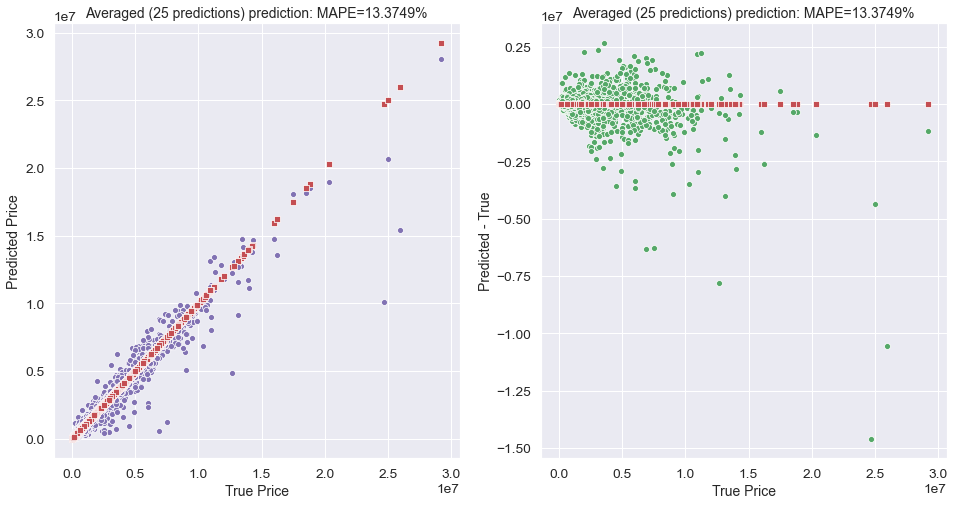

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged'], marker='o', color='m')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted Price", fontsize=FONT_SIZE)


plt.subplot(1, 2, 2)
sns.scatterplot(data_meta_valid[target_name], data_meta_valid['Averaged']-data_meta_valid[target_name], marker='o', color='g')
sns.scatterplot(data_meta_valid[target_name], data_meta_valid[target_name]-data_meta_valid[target_name], marker='s', color='r')

plt.title("Averaged ({} predictions) prediction: MAPE={:.4f}%"
          .format(data_meta_valid.shape[1]-2, mape_averaged_meta_valid), fontsize=FONT_SIZE)
plt.xlabel("True Price", fontsize=FONT_SIZE)
plt.ylabel("Predicted - True", fontsize=FONT_SIZE)

plt.show()

<div class="alert alert-block alert-danger">   

    OMITTED
    SEE COMREHENSIVE VERSION
    
        7.1.2 Weighted average prediction  (*LinerRegression*)
    7.2 Stacking  with LightGBM
        7.2.1 Optimization of  meta model
        7.2.2 Collect an ensemle of nearly best meta models
        7.2.3. About the best meta model. Feature importance.
    7.3 Averaged over $\sqrt{N}$ and $N$ best meta models prediction (*LGBMRegressor*)

In [32]:
performance_time = time.time() - total_time_start

In [33]:
def two_digit_presentation(x):
    if x < 10:
        return "0" + str(x)
    else:
        return str(x)
    

    
def two_digit_time_presentation(x):
    hours = x//3600
    minutes = ( x - 3600*hours) // 60
    seconds = x - 3600*hours - 60*minutes
    if hours > 0:
        ans = (two_digit_presentation(int(hours)) +  " h " 
               + two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    elif minutes > 0:
        ans = (two_digit_presentation(int(minutes)) + " min " 
               + two_digit_presentation(int(seconds)) + " sec")
    else:
        ans = (two_digit_presentation(round(seconds, 3)) + " sec")
    return ans

<div class="alert alert-block alert-info">
<div style="border:solid blue 2px; padding: 20px"> <h1 style="color:blue; margin-bottom:20px">
99 Results</h1>

</div>

In [35]:
print( "The full performance time is " + two_digit_time_presentation( performance_time ) )

The full performance time is 11 min 25 sec


## Appendix: Что ещё можно было бы сделать

1. Объединить `model` и `mark` в один признак.
2. Рефакторинг кода: есть остатки от предыдущих исследований с "висящими хвостами"
3. Сделать класс `LGBMBaging`:
  - принимает на вход параметры 
  - имеет метод `fit` (input: features_train, target_train)
  - имеет метод `predict` (input: features)
  - имеет метод `optimize` (желательно)